In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
!wget -nc https://raw.githubusercontent.com/TsamisG/SMS_Spam_Classifier/main/spam.csv

--2024-02-21 15:47:32--  https://raw.githubusercontent.com/TsamisG/SMS_Spam_Classifier/main/spam.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/plain]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.04s   

2024-02-21 15:47:32 (11.9 MB/s) - ‘spam.csv’ saved [503663/503663]



In [3]:
!head spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

In [4]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
df.columns = ['labels', 'data']

In [8]:
df

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


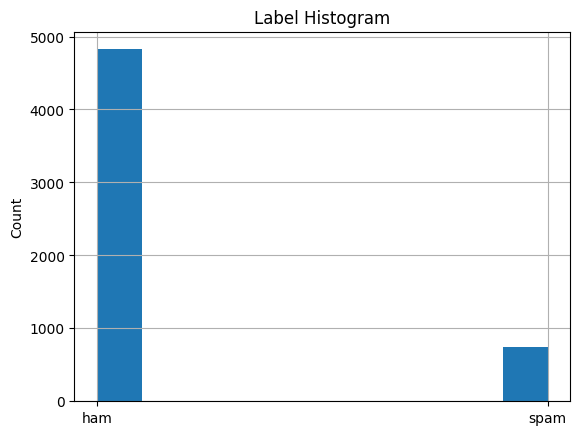

In [9]:
df['labels'].hist()
plt.title('Label Histogram')
plt.ylabel('Count')
plt.show()

In [10]:
df['bin_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
df

,labels,data,bin_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will Ì_ b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


In [11]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [12]:
df_train.shape, df_test.shape

((4457, 3), (1115, 3))

In [13]:
idx = 1
word2idx = {'<PAD>': 0}

In [14]:
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  for token in tokens:
    if token not in word2idx:
      word2idx[token] = idx
      idx += 1

In [15]:
print(f'Vocabulary Size: {len(word2idx)}')

Vocabulary Size: 11758


In [16]:
train_sentences_as_ints = []
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_ints = [word2idx[token] for token in tokens]
  train_sentences_as_ints.append(sentence_as_ints)

In [17]:
test_sentences_as_ints = []
for i, row in df_test.iterrows():
  tokens = row['data'].lower().split()
  sentence_as_ints = [word2idx[token] for token in tokens if token in word2idx]
  test_sentences_as_ints.append(sentence_as_ints)

In [18]:
len(train_sentences_as_ints), len(test_sentences_as_ints)

(4457, 1115)

In [19]:
def batch_generator(X, Y, batch_size=32):
  X, Y = shuffle(X, Y)
  N = len(Y)
  n_batches = int(np.ceil(N / batch_size))

  for i in range(n_batches):
    X_batch = X[i*batch_size:(i+1)*batch_size]
    Y_batch = Y[i*batch_size:(i+1)*batch_size]

    max_len_in_batch = np.max([len(x) for x in X_batch])
    for j in range(len(X_batch)):
      x = X_batch[j]
      pad = [0] * (max_len_in_batch - len(x))
      X_batch[j] = pad + x

    X_batch = torch.from_numpy(np.array(X_batch)).long()
    Y_batch = torch.from_numpy(np.array(Y_batch)).long()

    yield X_batch, Y_batch

In [20]:
class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, learning_rate):
    super(RNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.embed = nn.Embedding(self.V, self.D)
    self.LSTM = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)

    self.criterion = nn.BCEWithLogitsLoss()
    self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

  def forward(self, X):
    h0 = torch.zeros(self.L, X.size(0), self.M)
    c0 = torch.zeros(self.L, X.size(0), self.M)

    out = self.embed(X)

    out, _ = self.LSTM(out, (h0, c0))

    out, _ = torch.max(out, 1)

    out = self.fc(out)
    return out

  def fit(self, X_train, Y_train, X_test, Y_test, epochs=100):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for ep in range(epochs):
      batch_losses = []
      for inputs, targets in batch_generator(X_train, Y_train):
        targets = targets.view(-1, 1).float()
        self.optimizer.zero_grad()

        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        batch_losses.append(loss.item())
        loss.backward()
        self.optimizer.step()

      train_loss = np.mean(batch_losses)
      train_losses[ep] = train_loss

      batch_losses = []
      with torch.no_grad():
        for inputs, targets in batch_generator(X_test, Y_test):
          targets = targets.view(-1, 1).float()
          outputs = self(inputs)
          test_loss = self.criterion(outputs, targets)
          batch_losses.append(test_loss)
        test_loss = np.mean(batch_losses)
        test_losses[ep] = test_loss

      print(f'Epoch [ {ep+1} / {epochs} ]: Train Loss: {train_losses[ep]:.3f} | Test Loss: {test_losses[ep]:.3f}')

    return train_losses, test_losses

  def score(self, X_train, Y_train, X_test, Y_test):
    train_accuracies = []
    test_accuracies = []

    with torch.no_grad():
      for inputs, targets in batch_generator(X_train, Y_train):
        targets = targets.view(-1, 1).float()
        predictions = (model(inputs) > 0).float()
        corrects = torch.zeros_like(targets)
        corrects[targets == predictions] = 1
        train_accuracies.append(corrects.mean())

      for inputs, targets in batch_generator(X_test, Y_test):
        targets = targets.view(-1, 1).float()
        predictions = (model(inputs) > 0).float()
        corrects = torch.zeros_like(targets)
        corrects[targets == predictions] = 1
        test_accuracies.append(corrects.mean())
    return np.mean(train_accuracies), np.mean(test_accuracies)

In [21]:
model = RNN(len(word2idx), 10, 2, 1, 1, learning_rate=0.01)

In [22]:
train_losses, test_losses = model.fit(train_sentences_as_ints, df_train['bin_labels'],
                                      test_sentences_as_ints, df_test['bin_labels'],
                                      epochs=20)

Epoch [ 1 / 20 ]: Train Loss: 0.501 | Test Loss: 0.330
Epoch [ 2 / 20 ]: Train Loss: 0.210 | Test Loss: 0.173
Epoch [ 3 / 20 ]: Train Loss: 0.104 | Test Loss: 0.139
Epoch [ 4 / 20 ]: Train Loss: 0.065 | Test Loss: 0.124
Epoch [ 5 / 20 ]: Train Loss: 0.050 | Test Loss: 0.104
Epoch [ 6 / 20 ]: Train Loss: 0.037 | Test Loss: 0.119
Epoch [ 7 / 20 ]: Train Loss: 0.030 | Test Loss: 0.107
Epoch [ 8 / 20 ]: Train Loss: 0.024 | Test Loss: 0.096
Epoch [ 9 / 20 ]: Train Loss: 0.023 | Test Loss: 0.097
Epoch [ 10 / 20 ]: Train Loss: 0.020 | Test Loss: 0.094
Epoch [ 11 / 20 ]: Train Loss: 0.019 | Test Loss: 0.100
Epoch [ 12 / 20 ]: Train Loss: 0.018 | Test Loss: 0.102
Epoch [ 13 / 20 ]: Train Loss: 0.016 | Test Loss: 0.096
Epoch [ 14 / 20 ]: Train Loss: 0.016 | Test Loss: 0.124
Epoch [ 15 / 20 ]: Train Loss: 0.016 | Test Loss: 0.103
Epoch [ 16 / 20 ]: Train Loss: 0.016 | Test Loss: 0.112
Epoch [ 17 / 20 ]: Train Loss: 0.015 | Test Loss: 0.103
Epoch [ 18 / 20 ]: Train Loss: 0.014 | Test Loss: 0.098
E

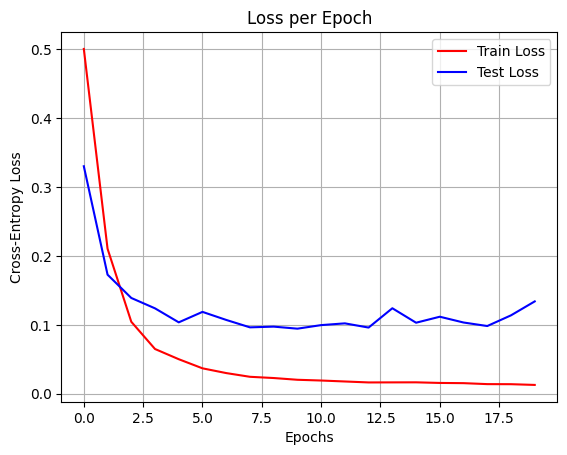

In [23]:
fig, ax = plt.subplots()
ax.plot(train_losses, color='red', label='Train Loss')
ax.plot(test_losses, color='blue',label='Test Loss')
ax.set(title='Loss per Epoch',
       xlabel='Epochs',
       ylabel='Cross-Entropy Loss')
ax.legend()
ax.grid()
plt.show()

In [24]:
train_accuracy, test_accuracy = model.score(train_sentences_as_ints, df_train['bin_labels'],
                                            test_sentences_as_ints, df_test['bin_labels'])

In [25]:
print(f'Classification Rates | Train Dataset: {train_accuracy*100:.2f}% | Test Dataset: {test_accuracy*100:.2f}%')

Classification Rates | Train Dataset: 99.78% | Test Dataset: 97.18%


In [26]:
out2cat = lambda x: 'The SMS is Spam.' if x > 0 else 'The SMS is Safe.'

In [27]:
text = df_test.sample()
text

,labels,data,bin_labels
4585,spam,"Mila, age23, blonde, new in UK. I look sex wit...",1


In [28]:
text['data'].item()

'Mila, age23, blonde, new in UK. I look sex with UK guys. if u like fun with me. Text MTALK to 69866.18 . 30pp/txt 1st 5free. å£1.50 increments. Help08718728876'

In [29]:
tokens = text['data'].item().lower().split()
input = [word2idx[token] for token in tokens if token in word2idx]
input

[10686,
 10687,
 10688,
 98,
 218,
 5831,
 88,
 811,
 3187,
 222,
 2639,
 7646,
 124,
 44,
 202,
 3524,
 222,
 518,
 295,
 10689,
 22,
 10690,
 279,
 10691,
 400,
 10692,
 954,
 10693,
 10694]

In [30]:
input = torch.from_numpy(np.array(input).reshape(1, -1)).long()
input.shape

torch.Size([1, 29])

In [31]:
with torch.no_grad():
  print(out2cat(model(input).item()))

The SMS is Spam.


In [32]:
my_sms = 'Hey, its me. Wanna hang out later? Call me'
tokens = my_sms.lower().split()
input = [word2idx[token] for token in tokens if token in word2idx]
input = torch.from_numpy(np.array(input).reshape(1, -1)).long()
with torch.no_grad():
  print(out2cat(model(input).item()))

The SMS is Safe.


In [33]:
my_sms = 'CONGRATZ UVE WON ONE MILLION DOLLARS! SEND ME UR CREDIT CARD INFORMATION TO RECEIVE THE PRIZE!'
tokens = my_sms.lower().split()
input = [word2idx[token] for token in tokens if token in word2idx]
input = torch.from_numpy(np.array(input).reshape(1, -1)).long()
with torch.no_grad():
  print(out2cat(model(input).item()))

The SMS is Spam.


In [34]:
torch.save(model.state_dict, 'SMS_Spam_Detector_Model.pt')